In [63]:
import pandas as pd
import numpy as np

def get_oip_1p():
    url = "http://openinsider.com/screener?s=&o=&pl=&ph=&ll=&lh=&fd=-1&fdr=05%2F01%2F2022+-+05%2F01%2F2023&td=0&tdr=&fdlyl=&fdlyh=&daysago=&xp=1&vl=&vh=&ocl=&och=&sic1=-1&sicl=100&sich=9999&grp=0&nfl=&nfh=&nil=&nih=&nol=&noh=&v2l=&v2h=&oc2l=&oc2h=&sortcol=0&cnt=500&page=1"
    # Read all tables on the page
    tables = pd.read_html(url)
    # Grab the table that has the purchase data (index 5 based on your inspection)
    df = tables[11]
    df.columns = (
    pd.Index(df.columns.map(str))
    .str.replace(r'\s+', '_', regex=True)  # replaces spaces, \xa0, tabs, etc.
    .str.strip()
    .str.lower() )

    df.columns = pd.Index(df.columns.map(str)).str.replace(' ', '_', regex=True)
    df = df[df["trade_type"].str.contains("Purchase", na=False)]
    df["trade_date"] = pd.to_datetime(df["trade_date"], errors='coerce')
    df["price"] = df["price"].replace('[$,]', '', regex=True).astype(float)
    df["qty"] = df["qty"].replace('[+,]', '', regex=True).astype(int)
    df["d_own_plus%"] = (
    df["δown"]
    .replace("New", np.nan)
    .replace(r'>', '', regex=True)          # remove '>' character
    .replace(r'[\+,%]', '', regex=True)     # remove '+', ',', '%'
    .astype(float)
)

    return df

   
oip = get_oip_1p()
print(oip.head())
print('number of rows:', len(oip))
tickers = oip["ticker"].unique().tolist()
print("Sample first 10 tickers for Form 4 scraping:", tickers[:10])

     x          filing_date trade_date ticker  \
0    D  2023-05-01 21:31:53 2023-04-28   USGO   
1    D  2023-05-01 20:33:46 2023-05-01   BANC   
2  NaN  2023-05-01 19:51:48 2023-05-01     PI   
3   DM  2023-05-01 19:29:20 2023-04-26   FOMC   
4  NaN  2023-05-01 19:08:00 2023-04-27   KREF   

                         company_name          insider_name          title  \
0                U.S. Goldmining Inc.  Bukacheva Aleksandra            Dir   
1            Banc of California, Inc.         Wolff Jared M      Pres, CEO   
2                          Impinj Inc          Sanghi Steve            Dir   
3                Fomo Worldwide, Inc.       Grover Vikram P  CEO, Dir, 10%   
4  Kkr Real Estate Finance Trust Inc.       Salem Matthew A            CEO   

     trade_type  price      qty    owned   δown        value  1d  1w  1m  6m  \
0  P - Purchase   9.15     1000     1000    New      +$9,150 NaN NaN NaN NaN   
1  P - Purchase  11.10     6769   273252    +3%     +$75,118 NaN NaN NaN NaN

In [68]:
import yfinance as yf
from pandas.tseries.offsets import BDay
from datetime import timedelta


def attach_forward_returns_openinsider(df, window=30):
    result_rows = []

    for ticker in df["ticker"].unique():
        df_ticker = df[df["ticker"] == ticker].copy()
        if df_ticker.empty:
            continue

        # Determine price range needed
        min_date = df_ticker["trade_date"].min() - timedelta(days=1)
        max_date = df_ticker["trade_date"].max() + timedelta(days=window + 5)

        # Download historical prices
        price_df = yf.download(ticker, start=min_date, end=max_date, auto_adjust=True, progress=False)
        if price_df.empty:
            continue

        price_df = price_df[["Close"]].rename(columns={"Close": "close"})
        price_df.index = pd.to_datetime(price_df.index)

        for _, row in df_ticker.iterrows():
            trade_date = pd.to_datetime(row["trade_date"])

            try:
                # Get closest available trading day
                event_ts = price_df.index[price_df.index.get_indexer([trade_date], method="nearest")[0]]
                fwd_ts = event_ts + BDay(window)
                if fwd_ts not in price_df.index:
                    fwd_ts = price_df.index[price_df.index.get_indexer([fwd_ts], method="nearest")[0]]

                start_price = price_df.loc[event_ts, "close"]
                fwd_price = price_df.loc[fwd_ts, "close"]
                fwd_return = (fwd_price - start_price) / start_price

                result_rows.append({
                    "ticker": str(ticker),
                    "trade_date": str(row["trade_date"]),
                    "price": float(row["price"]),
                    "qty": float(row["qty"]),
                    "d_own_plus%": row.get("d_own_plus%", np.nan),
                    "start_price": float(start_price.iloc[0]),
                    "fwd_price": float(fwd_price.iloc[0]),
                    "fwd_return": float(fwd_return.iloc[0]),
                })

            except Exception as e:
                print(f"Failed to process {ticker} on {trade_date.date()}: {e}")
                continue

    return pd.DataFrame(result_rows)
#df_returns = attach_forward_returns_openinsider(oip, window=30)
#print(df_returns.head())


C:\Users\John DeForest\AppData\Local\Temp\ipykernel_55396\1206529762.py:46: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "start_price": float(start_price),
C:\Users\John DeForest\AppData\Local\Temp\ipykernel_55396\1206529762.py:47: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "fwd_price": float(fwd_price),
C:\Users\John DeForest\AppData\Local\Temp\ipykernel_55396\1206529762.py:48: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "fwd_return": float(fwd_return),
C:\Users\John DeForest\AppData\Local\Temp\ipykernel_55396\1206529762.py:46: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "start_price": fl

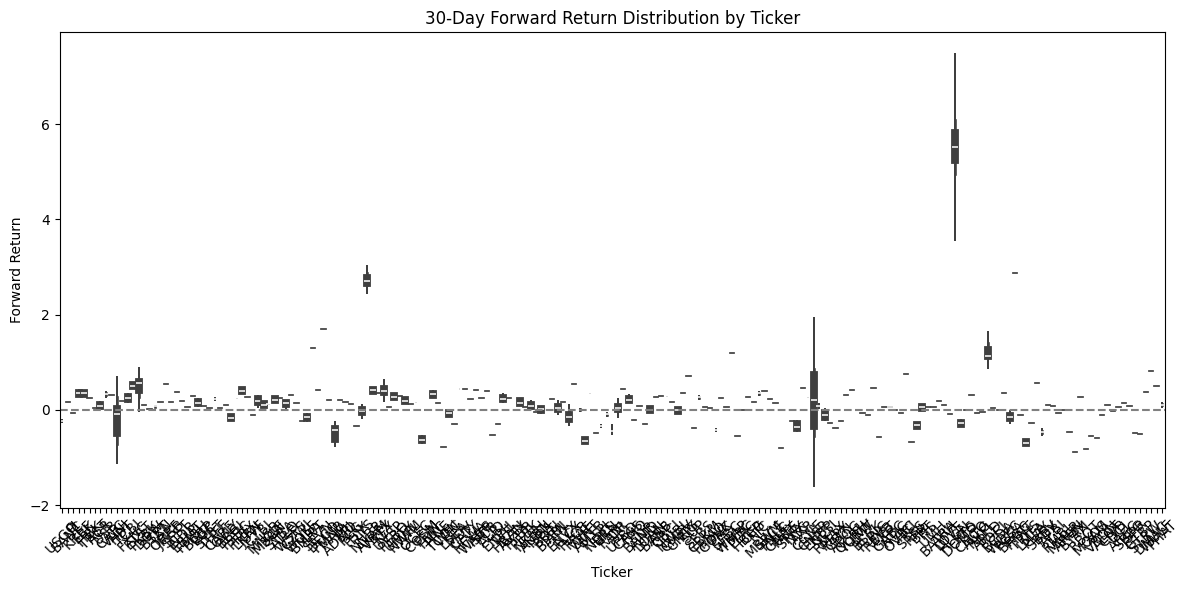


Summary Statistics by Ticker (30-Day Forward Return %):
    ticker  count  mean_pct    median  std_pct       min       max
0      ACR      2      9.15  0.091513     2.95  0.070640  0.112385
1     ADMQ      1     20.00  0.200000      NaN  0.200000  0.200000
2     AFBI      1      9.11  0.091097      NaN  0.091097  0.091097
3      AHH      2     11.14  0.111429     0.00  0.111429  0.111429
4     AIMD      1    -29.67 -0.296703      NaN -0.296703 -0.296703
..     ...    ...       ...       ...      ...       ...       ...
198   WRAP      1    120.31  1.203125      NaN  1.203125  1.203125
199   WSFS      1     32.31  0.323102      NaN  0.323102  0.323102
200   WULF      1     50.35  0.503497      NaN  0.503497  0.503497
201    XOS      1    -58.50 -0.584967      NaN -0.584967 -0.584967
202   YORW      8    -12.49 -0.125664     0.21 -0.125664 -0.119738

[203 rows x 7 columns]


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

hold_dur = 253 #trading days stock held
# TODO for actual backtesting sim, account for delay in reporting form4s!!!

# Get returns from the OpenInsider-enriched dataset
df_returns = attach_forward_returns_openinsider(oip, window=hold_dur)

# Drop any NaNs in return
df_returns = df_returns.dropna(subset=['fwd_return'])

# --- Visualization ---
plt.figure(figsize=(12, 6))
sns.violinplot(data=df_returns, x='ticker', y='fwd_return')
plt.axhline(0, linestyle='--', color='gray')
plt.title("30-Day Forward Return Distribution by Ticker")
plt.ylabel("Forward Return")
plt.xlabel("Ticker")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# --- Summary Statistics ---
summary = df_returns.groupby('ticker')['fwd_return'].agg(['count', 'mean', 'median', 'std', 'min', 'max']).reset_index()
summary['mean_pct'] = (summary['mean'] * 100).round(2)
summary['std_pct'] = (summary['std'] * 100).round(2)

print(f"\nSummary Statistics by Ticker ({hold_dur}-Day Forward Return %):")
print(summary[['ticker', 'count', 'mean_pct', 'median', 'std_pct', 'min', 'max']])


In [67]:
print(df_returns.head())
overall_median = df_returns["fwd_return"].median()
overall_mean = df_returns["fwd_return"].mean()

print(f"Overall Median 30-Day Forward Return: {overall_median:.4f} ({overall_median*100:.2f}%)")
print(f"Overall Mean 30-Day Forward Return: {overall_mean:.4f} ({overall_mean*100:.2f}%)")


  ticker           trade_date  price      qty  d_own_plus%  start_price  \
0   USGO  2023-04-28 00:00:00   9.15   1000.0          NaN         9.17   
1   USGO  2023-04-25 00:00:00   8.96  48786.0          1.0         9.04   
2   USGO  2023-04-19 00:00:00  10.00   7600.0          4.0         9.04   
3   USGO  2023-04-19 00:00:00  10.00   3500.0          7.0         9.04   
4   USGO  2023-04-19 00:00:00  10.00   1000.0          NaN         9.04   

   fwd_price  fwd_return  
0        7.0   -0.236641  
1        7.0   -0.225664  
2        7.0   -0.225664  
3        7.0   -0.225664  
4        7.0   -0.225664  
Overall Median 30-Day Forward Return: 0.1089 (10.89%)
Overall Mean 30-Day Forward Return: 0.1130 (11.30%)


In [71]:
#2 sep rows for ea transaction

import yfinance as yf
from pandas.tseries.offsets import BDay
from datetime import timedelta
import numpy as np
import pandas as pd

def attach_multiple_forward_returns_openinsider(df, windows=[5, 10, 30, 90, 252]):
    result_rows = []
    
    for ticker in df["ticker"].unique():
        df_ticker = df[df["ticker"] == ticker].copy()
        if df_ticker.empty:
            continue
        df_ticker["filing_date"] = pd.to_datetime(df_ticker["filing_date"], errors="coerce")

        min_date = df_ticker["filing_date"].min() - timedelta(days=1)
        max_date = df_ticker["filing_date"].max() + timedelta(days=max(windows) + 5)

        price_df = yf.download(ticker, start=min_date, end=max_date, auto_adjust=True, progress=False)
        if price_df.empty:
            continue

        price_df = price_df[["Close"]].rename(columns={"Close": "close"})
        price_df.index = pd.to_datetime(price_df.index)

        for _, row in df_ticker.iterrows():
            filing_date = pd.to_datetime(row["filing_date"])
            try:
                event_ts = price_df.index[price_df.index.get_indexer([filing_date], method="nearest")[0]]
                start_price = price_df.loc[event_ts, "close"]

                return_data = {"start_price": float(start_price.iloc[0])}
                for w in windows:
                    fwd_ts = event_ts + BDay(w)
                    if fwd_ts not in price_df.index:
                        fwd_ts = price_df.index[price_df.index.get_indexer([fwd_ts], method="nearest")[0]]
                    fwd_price = price_df.loc[fwd_ts, "close"]
                    return_data[f"return_{w}d"] = float((fwd_price.iloc[0] - start_price.iloc[0]) / start_price.iloc[0])

                merged_row = row.to_dict()
                merged_row.update(return_data)
                result_rows.append(merged_row)

            except Exception as e:
                print(f"Failed to process {ticker} on {filing_date.date()}: {e}")
                continue

    return pd.DataFrame(result_rows)

dfr2 = attach_multiple_forward_returns_openinsider(oip, windows=[5, 10, 30, 90, 252])

C:\Users\John DeForest\AppData\Local\Temp\ipykernel_55396\311908931.py:34: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return_data = {"start_price": float(start_price)}
C:\Users\John DeForest\AppData\Local\Temp\ipykernel_55396\311908931.py:40: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return_data[f"return_{w}d"] = float((fwd_price - start_price) / start_price)
C:\Users\John DeForest\AppData\Local\Temp\ipykernel_55396\311908931.py:34: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return_data = {"start_price": float(start_price)}
C:\Users\John DeForest\AppData\Local\Temp\ipykernel_55396\311908931.py:40: FutureWarning: Calling float on a single element Series is deprecated and will raise a T

In [ ]:
print(dfr2.head())
#sort by 

   x         filing_date trade_date ticker          company_name  \
0  D 2023-05-01 21:31:53 2023-04-28   USGO  U.S. Goldmining Inc.   
1  M 2023-04-27 19:52:00 2023-04-25   USGO  U.S. Goldmining Inc.   
2  D 2023-04-21 18:06:00 2023-04-19   USGO  U.S. Goldmining Inc.   
3  D 2023-04-21 18:04:18 2023-04-19   USGO  U.S. Goldmining Inc.   
4  D 2023-04-21 18:02:56 2023-04-19   USGO  U.S. Goldmining Inc.   

             insider_name title    trade_type  price    qty  ...  1w  1m  6m  \
0    Bukacheva Aleksandra   Dir  P - Purchase   9.15   1000  ... NaN NaN NaN   
1         Goldmining Inc.   10%  P - Purchase   8.96  48786  ... NaN NaN NaN   
2  Still Alastair Charles   Dir  P - Purchase  10.00   7600  ... NaN NaN NaN   
3    Smith Timothy Robert   CEO  P - Purchase  10.00   3500  ... NaN NaN NaN   
4    Bukacheva Aleksandra   Dir  P - Purchase  10.00   1000  ... NaN NaN NaN   

   d_own_plus%  start_price  return_5d  return_10d  return_30d  return_90d  \
0          NaN         9.38   0.

In [ ]:
#2 sep rows for ea transaction

import yfinance as yf
from pandas.tseries.offsets import BDay
from datetime import timedelta
import numpy as np
import pandas as pd

def attach_multiple_forward_returns_openinsider(df, windows=[5, 10, 30, 90, 252]):
    #result_rows = []
    newdf = pd.DataFrame()
    newdf = pd.DataFrame(columns=['x',"ticker", "filing_date",'trade_date', "start_price",'company_name','insider_name','qty','owned','d_own','value','d_own_plus%'] + [f"price_{w}d" for w in windows])
    for index, row in df.iterrows():
        newdf['x'] = row['x']
        newdf['ticker'] = row['ticker']
        newdf['filing_date'] = row['filing_date']
        newdf['trade_date'] = row['trade_date']
        newdf['company_name'] = row['company_name']
        newdf['insider_name'] = row['insider_name']
        newdf['qty'] = row['qty']
        newdf['owned'] = row['owned']
        newdf['d_own'] = row['δown']
        newdf['value'] = row['value']
        newdf['d_own_plus%'] = row['d_own_plus%']
        newdf['start_price'] = row['price']
        for w in windows:
            newdf[f"price_{w}d"] = #GET PRICE HERE

    # for ticker in df["ticker"].unique():
    #     df_ticker = df[df["ticker"] == ticker].copy()
    #     if df_ticker.empty:
    #         continue
    #     df_ticker["filing_date"] = pd.to_datetime(df_ticker["filing_date"], errors="coerce")

    #     min_date = df_ticker["filing_date"].min() - timedelta(days=1)
    #     max_date = df_ticker["filing_date"].max() + timedelta(days=max(windows) + 5)

    #     price_df = yf.download(ticker, start=min_date, end=max_date, auto_adjust=True, progress=False)
    #     if price_df.empty:
    #         continue

    #     price_df = price_df[["Close"]].rename(columns={"Close": "close"})
    #     price_df.index = pd.to_datetime(price_df.index)

    #     for _, row in df_ticker.iterrows():
    #         filing_date = pd.to_datetime(row["filing_date"])
    #         try:
    #             event_ts = price_df.index[price_df.index.get_indexer([filing_date], method="nearest")[0]]
    #             start_price = price_df.loc[event_ts, "close"]

    #             return_data = {"start_price": float(start_price.iloc[0])}
    #             for w in windows:
    #                 fwd_ts = event_ts + BDay(w)
    #                 if fwd_ts not in price_df.index:
    #                     fwd_ts = price_df.index[price_df.index.get_indexer([fwd_ts], method="nearest")[0]]
    #                 fwd_price = price_df.loc[fwd_ts, "close"]
    #                 return_data[f"return_{w}d"] = float((fwd_price.iloc[0] - start_price.iloc[0]) / start_price.iloc[0])

    #             merged_row = row.to_dict()
    #             merged_row.update(return_data)
    #             result_rows.append(merged_row)

    #         except Exception as e:
    #             print(f"Failed to process {ticker} on {filing_date.date()}: {e}")
    #             continue

    return pd.DataFrame(result_rows)

dfr2 = attach_multiple_forward_returns_openinsider(oip, windows=[5, 10, 30, 90, 252])

In [81]:
import pandas as pd
import yfinance as yf
from pandas.tseries.offsets import BDay

def attach_multiple_forward_returns_openinsider(df, windows=[5, 10, 30, 90, 252]):
    result_cols = ['x', "ticker", "filing_date", 'trade_date', 'company_name',
                   'insider_name', 'qty', 'owned', 'd_own', 'value', 'd_own_plus%',
                   'start_price'] + [f"price_{w}d" for w in windows]
    newdf = pd.DataFrame(columns=result_cols)

    for index, row in df.iterrows():
        ticker = row['ticker']
        filing_date = pd.to_datetime(row['filing_date'])

        try:
            hist = yf.download(
                ticker,
                start=filing_date - BDay(2),
                end=filing_date + BDay(max(windows) + 10),
                auto_adjust=True,
                progress=False
            )

            if hist.empty:
                continue

            hist.index = pd.to_datetime(hist.index)
            hist = hist[['Close']].rename(columns={'Close': 'close'})

            # --- Define start_ts before price access ---
            try:
                start_ts = hist.index[hist.index.get_indexer([filing_date], method='nearest')[0]]
                start_price_val = hist.loc[start_ts, 'close']
                start_price = float(start_price_val.iloc[0]) if isinstance(start_price_val, pd.Series) else float(start_price_val)
            except Exception as e:
                print(f"Error locating start price for {ticker} on {filing_date.date()}: {e}")
                continue

            price_dict = {}
            for w in windows:
                try:
                    fwd_ts = start_ts + BDay(w)
                    if fwd_ts not in hist.index:
                        fwd_ts = hist.index[hist.index.get_indexer([fwd_ts], method='nearest')[0]]
                    
                    fwd_price_val = hist.loc[fwd_ts, 'close']
                    price_dict[f"price_{w}d"] = float(fwd_price_val.iloc[0]) if isinstance(fwd_price_val, pd.Series) else float(fwd_price_val)

                except Exception as e:
                    price_dict[f"price_{w}d"] = None


            new_row = {
                'x': row.get('x'),
                'ticker': ticker,
                'filing_date': filing_date,
                'trade_date': row.get('trade_date'),
                'company_name': row.get('company_name'),
                'insider_name': row.get('insider_name'),
                'qty': row.get('qty'),
                'owned': row.get('owned'),
                'd_own': row.get('δown'),
                'value': row.get('value'),
                'd_own_plus%': row.get('d_own_plus%'),
                'start_price': start_price
            }
            new_row.update(price_dict)

            newdf = pd.concat([newdf, pd.DataFrame([new_row])], ignore_index=True)

        except Exception as e:
            print(f"Error processing {ticker} on {filing_date.date()}: {e}")
            continue

    return newdf
dfr3 = attach_multiple_forward_returns_openinsider(oip, windows=[5, 10, 30, 90, 252])

C:\Users\John DeForest\AppData\Local\Temp\ipykernel_55396\1207867106.py:69: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  newdf = pd.concat([newdf, pd.DataFrame([new_row])], ignore_index=True)

1 Failed download:
['FOMC']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['CSTR']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['SMMF']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['HMNF']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['CVCY']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['BECN']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['SCWX']: YFTzM

In [84]:
#print(dfr3.head())
#alter value column: remove +$ in front of value, and convert to float
dfr3['value'] = dfr3['value'].replace(r'[+\$,]', '', regex=True).astype(float)
#print(dfr3.head())
#sort by value
dfr3 = dfr3.sort_values(by='value', ascending=False)
print(dfr3.head(10))


       x ticker         filing_date trade_date  \
198    A    RIG 2023-04-25 18:58:23 2022-05-13   
197    A    RIG 2023-04-25 19:00:18 2022-05-13   
61     D   PIII 2023-04-28 18:12:45 2023-04-06   
166  NaN   ENPH 2023-04-26 16:39:28 2023-04-26   
122  NaN   FYBR 2023-04-27 16:02:52 2023-04-25   
124  NaN   FYBR 2023-04-27 16:01:55 2023-04-25   
123  NaN   FYBR 2023-04-27 16:02:23 2023-04-25   
125  NaN   FYBR 2023-04-27 16:00:56 2023-04-25   
127  NaN   FYBR 2023-04-27 16:00:12 2023-04-25   
113  NaN   ENPH 2023-04-27 16:36:48 2023-04-26   

                             company_name                       insider_name  \
198                       Transocean Ltd.              Mohn Frederik Wilhelm   
197                       Transocean Ltd.                        Perestroika   
61                P3 Health Partners Inc.  Chicago Pacific Founders Ugp, LLC   
166                  Enphase Energy, Inc.                  Rodgers Thurman J   
122  Frontier Communications Parent, Inc.        

In [85]:
import re

# Identify all price_xd columns with 1–3 digit day values
price_cols = [col for col in dfr3.columns if re.fullmatch(r'price_\d{1,3}d', col)]

# Compute return_xd = (price_xd - start_price) / start_price
for col in price_cols:
    days = col.split('_')[1]  # extract "xd"
    return_col = f"return_{days}"
    dfr3[return_col] = (dfr3[col] - dfr3['start_price']) / dfr3['start_price']
print(dfr3.head())

       x ticker         filing_date trade_date  \
198    A    RIG 2023-04-25 18:58:23 2022-05-13   
197    A    RIG 2023-04-25 19:00:18 2022-05-13   
61     D   PIII 2023-04-28 18:12:45 2023-04-06   
166  NaN   ENPH 2023-04-26 16:39:28 2023-04-26   
122  NaN   FYBR 2023-04-27 16:02:52 2023-04-25   

                             company_name                       insider_name  \
198                       Transocean Ltd.              Mohn Frederik Wilhelm   
197                       Transocean Ltd.                        Perestroika   
61                P3 Health Partners Inc.  Chicago Pacific Founders Ugp, LLC   
166                  Enphase Energy, Inc.                  Rodgers Thurman J   
122  Frontier Communications Parent, Inc.                Ares Management LLC   

         qty      owned d_own      value  ...    price_5d   price_10d  \
198  2000000   48018499   +4%  7500000.0  ...    5.650000    5.950000   
197  2000000   47996351   +4%  7500000.0  ...    5.650000    5.950000   

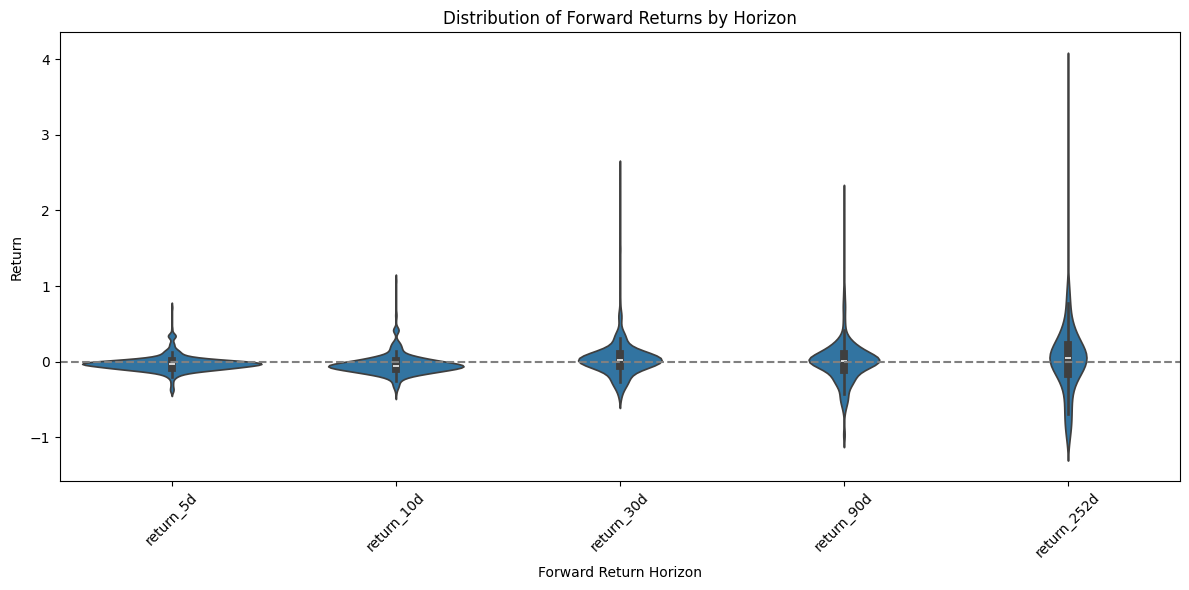

In [86]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import re

# Identify all return_xd columns
return_cols = [col for col in dfr3.columns if re.fullmatch(r'return_\d{1,3}d', col)]

# Melt the DataFrame for seaborn
df_viz = dfr3[return_cols].melt(var_name='Horizon', value_name='Return')
df_viz = df_viz.dropna()

# Plot
plt.figure(figsize=(12, 6))
sns.violinplot(data=df_viz, x='Horizon', y='Return', inner='box')
plt.axhline(0, linestyle='--', color='gray')
plt.title("Distribution of Forward Returns by Horizon")
plt.ylabel("Return")
plt.xlabel("Forward Return Horizon")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [87]:
import pandas as pd
import re

# Identify all return_xd columns
return_cols = [col for col in dfr3.columns if re.fullmatch(r'return_\d{1,3}d', col)]

# Compute summary statistics
summary_stats = dfr3[return_cols].agg(['count', 'mean', 'median', 'std', 'min', 'max']).T
summary_stats = summary_stats.sort_index()

# Display
print(summary_stats)



             count      mean    median       std       min       max
return_10d   445.0 -0.036886 -0.053333  0.135791 -0.414545  1.070866
return_252d  445.0  0.047651  0.050503  0.539955 -0.989225  3.768212
return_30d   445.0  0.038045  0.019802  0.249930 -0.465116  2.511811
return_5d    445.0 -0.024955 -0.031102  0.104882 -0.392000  0.717484
return_90d   445.0 -0.004312  0.008261  0.274677 -0.968729  2.176471


In [93]:
#now wgted avg returns:
dfr3['value_numeric'] = (
    dfr3['value']
    .astype(str)
    .str.replace(r'[\$+,]', '', regex=True)
    .replace('', pd.NA)
    .astype(float)
)
df= dfr3 

import re

return_cols = [col for col in dfr3.columns if re.fullmatch(r'return_\d{1,3}d', col)]

weighted_means = {}
for col in return_cols:
    valid = dfr3[[col, 'value_numeric']].dropna()
    weights = valid['value_numeric']
    returns = valid[col]
    weighted_mean = (returns * weights).sum() / weights.sum()
    weighted_means[col] = weighted_mean

# Display
for k, v in weighted_means.items():
    print(f"{k}: weighted mean return = {v:.4f}")


return_5d: weighted mean return = -0.0141
return_10d: weighted mean return = -0.0209
return_30d: weighted mean return = -0.0033
return_90d: weighted mean return = -0.0871
return_252d: weighted mean return = 0.0221


In [94]:
# Identify return columns
return_cols = [col for col in dfr3.columns if re.fullmatch(r'return_\d{1,3}d', col)]

# Dictionary to store Sharpe ratios
weighted_sharpes = {}

for col in return_cols:
    valid = dfr3[[col, 'value_numeric']].dropna()
    if len(valid) < 2:
        continue  # skip if too few valid rows

    r = valid[col]
    w = valid['value_numeric']

    # Weighted average return
    mean_r = np.average(r, weights=w)

    # Weighted standard deviation (formula for weighted sample std)
    average_diff_sq = np.average((r - mean_r) ** 2, weights=w)
    std_r = np.sqrt(average_diff_sq)

    # Sharpe ratio (risk-free rate assumed 0)
    sharpe = mean_r / std_r if std_r != 0 else np.nan
    weighted_sharpes[col] = sharpe

# Display
print("📈 Value-weighted Sharpe Ratios:")
for k, v in weighted_sharpes.items():
    print(f"{k}: Sharpe = {v:.4f}")
    

📈 Value-weighted Sharpe Ratios:
return_5d: Sharpe = -0.1312
return_10d: Sharpe = -0.0883
return_30d: Sharpe = -0.0061
return_90d: Sharpe = -0.2879
return_252d: Sharpe = 0.0569


In [96]:
# Filter: Only trades with value > median
value_threshold = df['value_numeric'].median()
df_big = df[df['value_numeric'] > value_threshold]

# Recalculate value-weighted Sharpe ratios for each return column
sharpe_ratios_big = {}

for col in df_big.columns:
    if col.startswith('return_'):
        weighted_mean = np.average(df_big[col], weights=df_big['value_numeric'])
        weighted_std = np.sqrt(np.average((df_big[col] - weighted_mean)**2, weights=df_big['value_numeric']))
        sharpe = weighted_mean / weighted_std if weighted_std != 0 else np.nan
        sharpe_ratios_big[col] = sharpe

# Display results
print("Value-weighted Sharpe ratios (Large Trades Only):")
for k, v in sharpe_ratios_big.items():
    print(f"{k}: Sharpe = {v:.4f}")

Value-weighted Sharpe ratios (Large Trades Only):
return_5d: Sharpe = -0.1287
return_10d: Sharpe = -0.0864
return_30d: Sharpe = -0.0070
return_90d: Sharpe = -0.2919
return_252d: Sharpe = 0.0573


In [97]:
import pandas as pd

def flag_clustered_buys(df, window_days=7, min_filings=2):
    df = df.copy()
    df['filing_date'] = pd.to_datetime(df['filing_date'])

    df['clustered'] = False

    for ticker in df['ticker'].unique():
        df_t = df[df['ticker'] == ticker].sort_values('filing_date')

        for i in range(len(df_t)):
            start_date = df_t.iloc[i]['filing_date']
            end_date = start_date + pd.Timedelta(days=window_days)
            count_in_window = df_t[(df_t['filing_date'] >= start_date) & (df_t['filing_date'] <= end_date)].shape[0]
            if count_in_window >= min_filings:
                df.loc[df_t.index[i], 'clustered'] = True

    return df
# Flag clusters
df_clustered = flag_clustered_buys(df, window_days=7, min_filings=2)

# Filter to clustered buys only
df_clusters = df_clustered[df_clustered['clustered']]

# Clean 'value' if needed
df_clusters['value_clean'] = df_clusters['value'].replace('[\$,]', '', regex=True).astype(float)

# Recalculate Sharpe ratios for clustered buys
sharpe_ratios_clusters = {}
for col in df_clusters.columns:
    if col.startswith('return_'):
        weighted_mean = np.average(df_clusters[col], weights=df_clusters['value_clean'])
        weighted_std = np.sqrt(np.average((df_clusters[col] - weighted_mean)**2, weights=df_clusters['value_clean']))
        sharpe = weighted_mean / weighted_std if weighted_std != 0 else np.nan
        sharpe_ratios_clusters[col] = sharpe

# Output
print("Value-weighted Sharpe ratios (Clustered Insider Buys):")
for k, v in sharpe_ratios_clusters.items():
    print(f"{k}: Sharpe = {v:.4f}")


<>:27: SyntaxWarning: invalid escape sequence '\$'
<>:27: SyntaxWarning: invalid escape sequence '\$'
C:\Users\John DeForest\AppData\Local\Temp\ipykernel_55396\1838400651.py:27: SyntaxWarning: invalid escape sequence '\$'
  df_clusters['value_clean'] = df_clusters['value'].replace('[\$,]', '', regex=True).astype(float)


Value-weighted Sharpe ratios (Clustered Insider Buys):
return_5d: Sharpe = -0.4594
return_10d: Sharpe = -0.5864
return_30d: Sharpe = -0.6773
return_90d: Sharpe = -0.6513
return_252d: Sharpe = 0.2074


C:\Users\John DeForest\AppData\Local\Temp\ipykernel_55396\1838400651.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clusters['value_clean'] = df_clusters['value'].replace('[\$,]', '', regex=True).astype(float)


In [100]:
#mkt cap small only:
def compute_market_cap_based_sharpe(df, cap_thresholds=(3e8, 2e9), return_cols=None):
    import numpy as np
    import pandas as pd

    if return_cols is None:
        return_cols = [col for col in df.columns if col.startswith("return_")]

    # Estimate market cap using owned shares * start price (very rough)
    df = df.copy()
    df["est_market_cap"] = pd.to_numeric(df["owned"], errors="coerce") * pd.to_numeric(df["start_price"], errors="coerce")
    
    # Drop rows with missing market cap or value
    df = df.dropna(subset=["est_market_cap", "value"])
    
    # Define masks
    micro_mask = df["est_market_cap"] < cap_thresholds[0]
    small_mask = (df["est_market_cap"] >= cap_thresholds[0]) & (df["est_market_cap"] <= cap_thresholds[1])

    def weighted_sharpe(df_sub, col):
        returns = pd.to_numeric(df_sub[col], errors="coerce")
        weights = pd.to_numeric(df_sub["value"], errors="coerce")
        mask = returns.notna() & weights.notna()
        if mask.sum() == 0:
            return np.nan
        w_ret = np.average(returns[mask], weights=weights[mask])
        w_std = np.sqrt(np.average((returns[mask] - w_ret)**2, weights=weights[mask]))
        return w_ret / w_std if w_std != 0 else np.nan

    results = {"Micro Cap": {}, "Small Cap": {}}
    for col in return_cols:
        results["Micro Cap"][col] = weighted_sharpe(df[micro_mask], col)
        results["Small Cap"][col] = weighted_sharpe(df[small_mask], col)

    return pd.DataFrame(results), df
sharpe_caps, microdf = compute_market_cap_based_sharpe(dfr3)
print(sharpe_caps)


             Micro Cap  Small Cap
return_5d    -0.440400  -0.553349
return_10d   -0.290479  -1.046801
return_30d    0.265177  -7.129906
return_90d    0.066425  -4.837110
return_252d   0.033442   1.006596


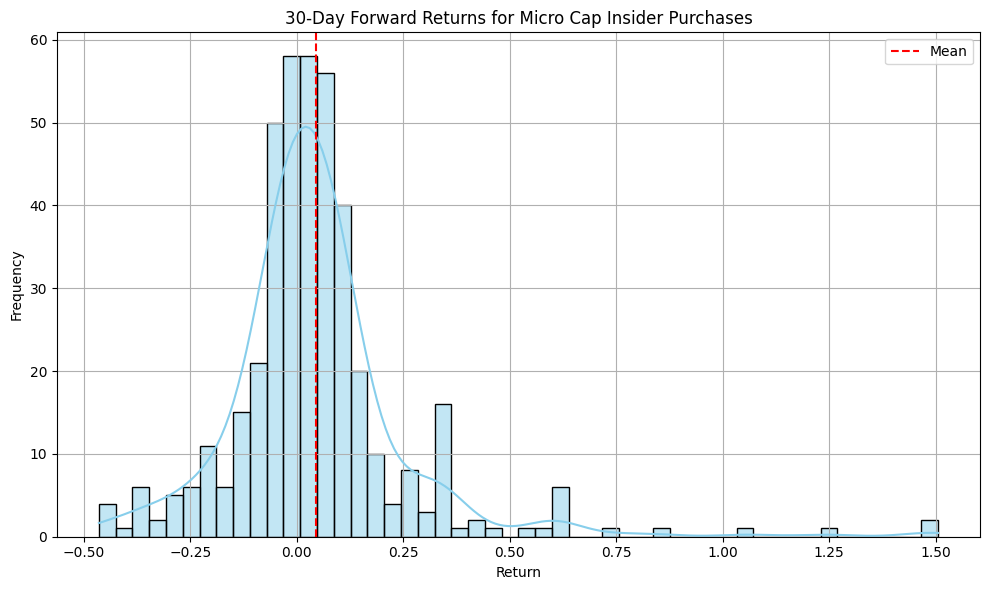

In [101]:
#30day microcap looks good:
import matplotlib.pyplot as plt
import seaborn as sns

dfr3=microdf.copy()
# Filter micro-cap entries
micro_mask = dfr3["est_market_cap"] < 3e8
micro_returns_30d = pd.to_numeric(dfr3.loc[micro_mask, "return_30d"], errors="coerce").dropna()

# Plot histogram
plt.figure(figsize=(10, 6))
sns.histplot(micro_returns_30d, bins=50, kde=True, color='skyblue')
plt.axvline(micro_returns_30d.mean(), color='red', linestyle='--', label='Mean')
plt.title("30-Day Forward Returns for Micro Cap Insider Purchases")
plt.xlabel("Return")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


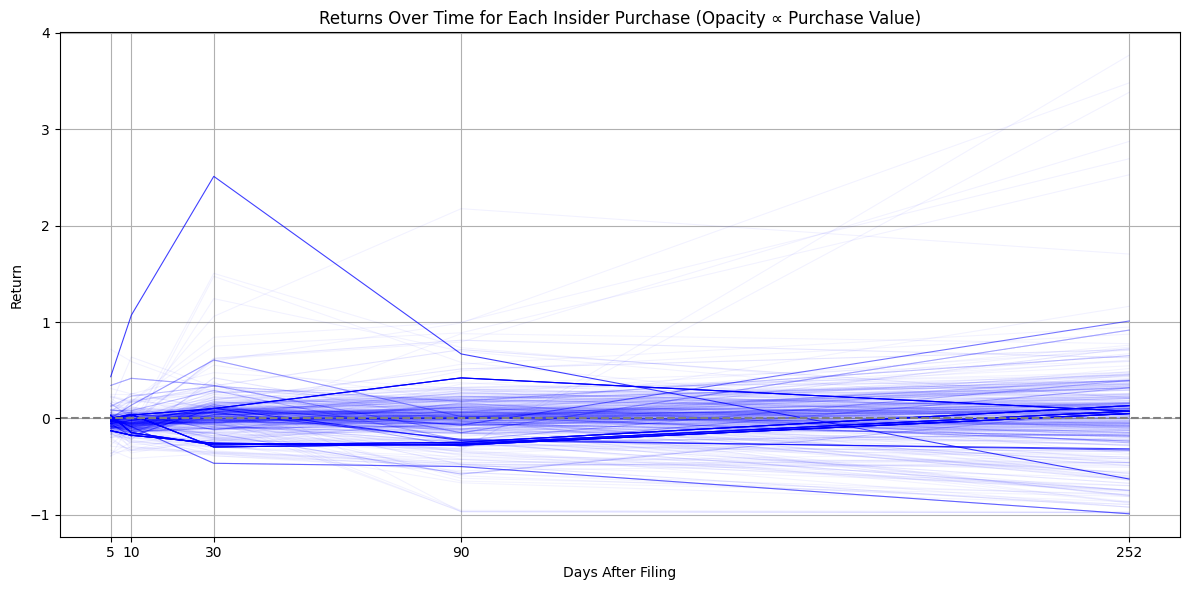

In [102]:
df = dfr3.copy()
df["value"] = pd.to_numeric(df["value"], errors="coerce")
return_cols = [col for col in df.columns if col.startswith("return_")]

# Normalize value for alpha scaling
max_value = df["value"].max()
min_value = df["value"].min()
df["alpha"] = (df["value"] - min_value) / (max_value - min_value)
df["alpha"] = df["alpha"].fillna(0.1).clip(0.05, 1.0)  # clip to avoid invisible points

# X positions for each return horizon (map: return_5d → x=5)
x_positions = [int(col.split("_")[1][:-1]) for col in return_cols]

# Plot
plt.figure(figsize=(12, 6))
for i, row in df.iterrows():
    yvals = [row[col] for col in return_cols]
    alpha = row["alpha"]
    plt.plot(x_positions, yvals, color='blue', alpha=alpha, linewidth=0.8)

# Formatting
plt.axhline(0, color='gray', linestyle='--')
plt.xticks(x_positions)
plt.xlabel("Days After Filing")
plt.ylabel("Return")
plt.title("Returns Over Time for Each Insider Purchase (Opacity ∝ Purchase Value)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [103]:
dfr3.to_csv("insider_trades_analysis.csv", index=False)
